In [1]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm.notebook import tqdm

from resnet import ResNet
from mahalanobis import compute_centers_cov, mahalanobis_score, metrics_eval


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
ID = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
OOD = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=False, num_workers=2)
ID_loader = torch.utils.data.DataLoader(ID, batch_size=500,shuffle=False,  num_workers=2)
OOD_loader = torch.utils.data.DataLoader(OOD, batch_size=500,shuffle=True,  num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [ ]:
# Computing Mahalanobis scores when using specific saved ResNet models.

# These validation accuracies will be used for the ablation study.
# They must correspond to specific trained and saved snapshots of the ResNet model.
accuracies = [5733, 6061, 6530, 6929, 7502, 8064, 8587, 8944, 9184]

for acc in tqdm(accuracies):
    model = torch.load(f'./models/resnet34/cifar10_{acc}')
    model.eval()

    layers = 17
    num_classes = 10
    num_per_class = 5000

    centers_cov_matrices = [compute_centers_cov(trainloader, model, layer, num_classes, num_per_class)
                            for layer in range(0,layers)]
    
    eps = 0.0000001 # This tiny quantity added to all covariance matrices is here to prevent divisions by zero
                    # from happening
    try:
        inv_cov_matrices = [torch.inverse(S+eps*torch.ones(S.size()).cuda()) for _, S in centers_cov_matrices]
    except RuntimeError:
        eps = eps * 1.05 # There still may be an error with the first value of eps

    # Building score dataset for logistic regression training

    magnitude = 0.005 # Chosen from a range of possible values by fine-tuning on last layer results
    X = []
    y = []
    
    quantity_target = 10000 # No need to compute more scores than this, the loop takes 1 min per batch of
                            # 1000 on our machine.
    
    for data_in, data_out in tqdm(zip(ID_loader,OOD_loader)):
        
        img_in, img_out = data_in[0].cuda(), data_out[0].cuda()
        
        features_in = np.zeros((len(img_in),layers))
        features_out = np.zeros((len(img_out),layers))
        
        for layer in range(layers):
            
            centers, _ = centers_cov_matrices[layer]
            inv_cov_matrix = inv_cov_matrices[layer]
            
            scores_in = mahalanobis_score(img_in, model, centers, inv_cov_matrix, magnitude=magnitude, layer=layer)
            scores_out = mahalanobis_score(img_out, model, centers, inv_cov_matrix, magnitude=magnitude, layer=layer)
            
            features_in[:,layer] = scores_in.cpu().numpy()
            features_out[:,layer] = scores_out.cpu().numpy()
            
        X = X + list(features_in) + list(features_out)
        y = y + [0]*len(scores_in) + [1]*len(scores_out)
        
        if len(y) >= quantity_target:
            break

    np.save(f'./data/scores/scoresCIFAR10_SVHN_{len(y)}_{acc}',X)
    np.save(f'./data/scores/labelsCIFAR10_SVHN_{len(y)}_{acc}',y)

Computing class centers; layer 0.



Computing covariance matrix; layer 0.



Computing class centers; layer 1.



Computing covariance matrix; layer 1.



Computing class centers; layer 2.



Computing covariance matrix; layer 2.



Computing class centers; layer 3.



Computing covariance matrix; layer 3.



Computing class centers; layer 4.



Computing covariance matrix; layer 4.



Computing class centers; layer 5.



Computing covariance matrix; layer 5.



Computing class centers; layer 6.



Computing covariance matrix; layer 6.



Computing class centers; layer 7.



Computing covariance matrix; layer 7.



Computing class centers; layer 8.



Computing covariance matrix; layer 8.



Computing class centers; layer 9.



Computing covariance matrix; layer 9.



Computing class centers; layer 10.



Computing covariance matrix; layer 10.



Computing class centers; layer 11.



Computing covariance matrix; layer 11.



Computing class centers; layer 12.



Computing covariance matrix; layer 12.



Computing class centers; layer 13.



Computing covariance matrix; layer 13.



Computing class centers; layer 14.



Computing covariance matrix; layer 14.



Computing class centers; layer 15.



Computing covariance matrix; layer 15.



Computing class centers; layer 16.



Computing covariance matrix; layer 16.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>: can only join a child process

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader

Computing class centers; layer 0.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/data


Computing covariance matrix; layer 0.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers

Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
w.join()    
self._shutdown_workers()  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only join a child process'    w.join()

AssertionError  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, 

Computing class centers; layer 1.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
self._shutdown_workers()    w.join()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
        w.join()assert self._parent_pid == os.getpid(), 'can only join a child process'

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
Assert


Computing covariance matrix; layer 1.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49aaf86dd0>
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
        assert self._parent_pid == os.getpid(), 'can only join a child process'w.join()
AssertionError
: can only join a child process
Exception ignored in:   File "/opt/conda


Computing class centers; layer 2.



Computing covariance matrix; layer 2.



Computing class centers; layer 3.



Computing covariance matrix; layer 3.



Computing class centers; layer 4.



Computing covariance matrix; layer 4.



Computing class centers; layer 5.



Computing covariance matrix; layer 5.



Computing class centers; layer 6.



Computing covariance matrix; layer 6.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



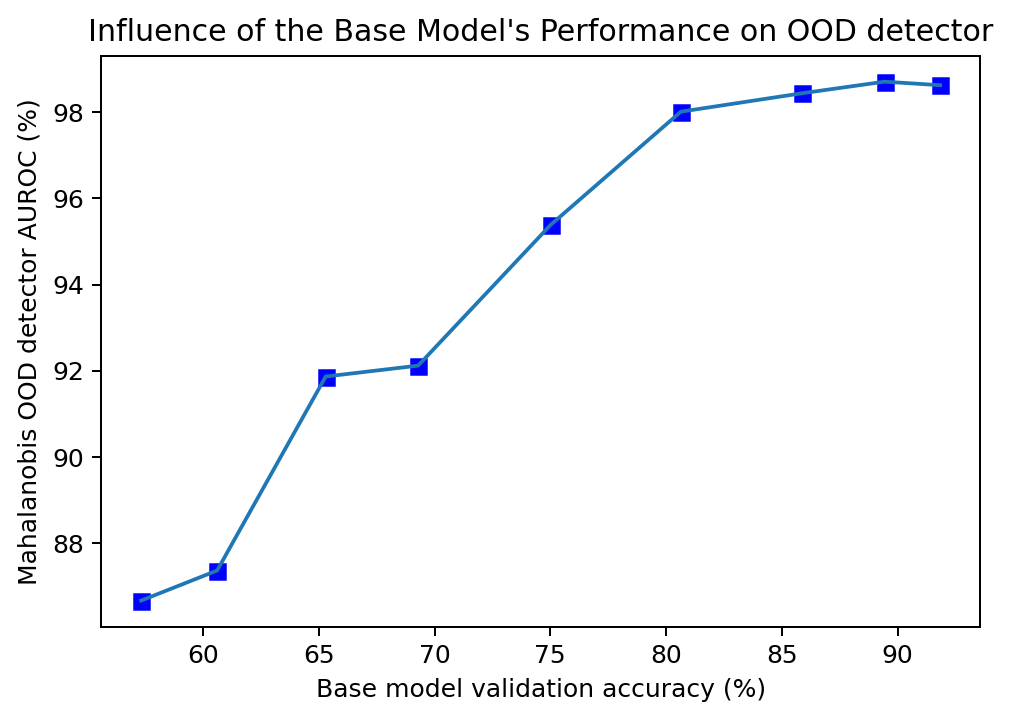

In [12]:
import matplotlib.pyplot as plt

# Accuracies to use for the plot. They must correspond to the files generated and saved with the previous cell.
accuracies = [5733, 6061, 6530, 6929, 7502, 8064, 8587, 8944, 9184]

roc_aucs = []

for acc in tqdm(accuracies):
    
    X = np.load(f"./data/scores/scoresCIFAR10_SVHN_10000_{acc}.npy")
    y = np.load(f"./data/scores/labelsCIFAR10_SVHN_10000_{acc}.npy")
    
    for k in range(17):
        X[:,k] = X[:,k]/max(X[:,k].max(), -X[:,k].min()) # Normalizing Mahalanobis scores

    y = 1-y # Inverting ID/OOD convention so that the LR's coefficients are positive
    
    X_train, X_test, y_train, y_test = train_test_split(np.array(X),y, test_size=0.5, shuffle=True)
    
    LR = LogisticRegression(max_iter=10000, verbose=0, fit_intercept=False)
    LR.fit(X_train,y_train)

    y_pred = LR.predict_proba(X_test)[:,1]
    scores_ID, scores_OOD = [], []
    
    # Converting results to the format used in the metrics_eval function
    for k in range(len(y_test)):
        if not y_test[k]:
            scores_OOD.append(y_pred[k])
        else:
            scores_ID.append(y_pred[k])
            
    roc_aucs.append(roc_auc_score(y_test, y_pred))

import seaborn as sns
plt.figure(figsize=(9*0.7,6*0.7), dpi=180)
X_plot = np.array(accuracies)/100
Y_plot = np.array(roc_aucs)*100
plt.plot(X_plot,Y_plot, 'bs')
plt.plot(X_plot,Y_plot)
plt.xlabel("Base model validation accuracy (%)")
plt.ylabel("Mahalanobis OOD detector AUROC (%)")
plt.title("Influence of the Base Model's Performance on OOD detector")
plt.show()